In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
import time


In [ ]:
## BND optimization algorithms

def fminsearchbnd(fun, x0, LB, UB, options, *args):
    # Size checks and defaults
    x0 = np.asarray(x0).flatten()
    n = len(x0)
    
    if LB is None:
        LB = -np.inf * np.ones(n)
    else:
        LB = np.asarray(LB).flatten()
        
    if UB is None:
        UB = np.inf * np.ones(n)
    else:
        UB = np.asarray(UB).flatten()
        
    if len(LB) != n or len(UB) != n:
        raise ValueError('x0 is incompatible in size with either LB or UB.')
    
    # Default options
    if options is None:
        options = {}
    
    # Struct to pass around
    params = {
        'args': args,
        'LB': LB,
        'UB': UB,
        'fun': fun,
        'n': n,
        'xsize': x0.shape
    }
    
    # Bound class
    params['BoundClass'] = np.zeros(n, dtype=int)
    for i in range(n):
        k = np.isfinite(LB[i]) + 2 * np.isfinite(UB[i])
        params['BoundClass'][i] = k
        if k == 3 and LB[i] == UB[i]:
            params['BoundClass'][i] = 4
    
    # Transform starting values
    x0u = np.zeros(n)
    k = 0
    for i in range(n):
        if params['BoundClass'][i] == 1:
            x0u[k] = 0 if x0[i] <= LB[i] else np.sqrt(x0[i] - LB[i])
            k += 1
        elif params['BoundClass'][i] == 2:
            x0u[k] = 0 if x0[i] >= UB[i] else np.sqrt(UB[i] - x0[i])
            k += 1
        elif params['BoundClass'][i] == 3:
            if x0[i] <= LB[i]:
                x0u[k] = -np.pi / 2
            elif x0[i] >= UB[i]:
                x0u[k] = np.pi / 2
            else:
                x0u[k] = 2 * (x0[i] - LB[i]) / (UB[i] - LB[i]) - 1
                x0u[k] = 2 * np.pi + np.arcsin(np.clip(x0u[k], -1, 1))
            k += 1
        elif params['BoundClass'][i] == 0:
            x0u[k] = x0[i]
            k += 1
    
    x0u = x0u[:k]
    
    if x0u.size == 0:
        x = xtransform(x0u, params)
        x = x.reshape(params['xsize'])
        fval = fun(x, *params['args'])
        return x, fval, 0, {'iterations': 0, 'funcCount': 1, 'algorithm': 'minimize', 'message': 'All variables were held fixed by the applied bounds'}
    
    # Minimization
    res = minimize(intrafun, x0u, args=(params,), method='Nelder-Mead', options=options)
    
    xu = res.x
    fval = res.fun
    exitflag = res.status
    output = {'iterations': res.nit, 'funcCount': res.nfev, 'algorithm': 'minimize', 'message': res.message}
    
    x = xtransform(xu, params)
    x = x.reshape(params['xsize'])
    
    return x, fval, exitflag, output

def intrafun(x, params):

    # Transforms variables and evaluates the original objective function.

    xtrans = xtransform(x, params)
    return params['fun'](xtrans.reshape(params['xsize']), *params['args'])

def xtransform(x, params):

    # Converts unconstrained variables into their original domains.

    xtrans = np.zeros(params['xsize'])
    k = 0
    for i in range(params['n']):
        if params['BoundClass'][i] == 1:
            xtrans[i] = params['LB'][i] + x[k]**2
            k += 1
        elif params['BoundClass'][i] == 2:
            xtrans[i] = params['UB'][i] - x[k]**2
            k += 1
        elif params['BoundClass'][i] == 3:
            xtrans[i] = (np.sin(x[k]) + 1) / 2
            xtrans[i] = xtrans[i] * (params['UB'][i] - params['LB'][i]) + params['LB'][i]
            xtrans[i] = np.clip(xtrans[i], params['LB'][i], params['UB'][i])
            k += 1
        elif params['BoundClass'][i] == 4:
            xtrans[i] = params['LB'][i]
        elif params['BoundClass'][i] == 0:
            xtrans[i] = x[k]
            k += 1
    return xtrans


In [ ]:
# Objective function
def MBW(dic, guesses):
    eta,theta,peeq=dic["eta"],dic["theta"],dic["peeq"]
    F_params = guesses
    Esim = (F_params[0] * np.exp(-F_params[1] * eta) - F_params[2] * np.exp(-F_params[3] * eta)) * theta**2 + F_params[2] * np.exp(-F_params[3] * eta)
    devia=(peeq-Esim)**2
    results={"Esim":Esim,"devia":devia}
    return results

def AMBW_Lou9p_fmin(guesses):

    # Define constants in dictionaries

    # Without Hydrogen charging (PEEQ)
    scenarios = {
        'CHD2': {'eta': 0.43921234095227807, 'theta': 0.8923667200021577, 'peeq': 1.21572351}, 
        'CHD4': {'eta': 0.420805013253624, 'theta': 0.9116832625639929, 'peeq': 1.3944546}, 
        'NDBR2p5': {'eta': 0.7051183282413369, 'theta': 0.003934203748212394, 'peeq': 0.647949036}, 
        'NDBR6': {'eta': 0.7710209769077397, 'theta': 0.047610828165876175, 'peeq': 1.03478765}, 
        'NDBR15': {'eta': 0.6886682481491765, 'theta': 0.2631436174337343, 'peeq': 1.0222435}, 
        'NDBR40': {'eta': 0.5882302503807374, 'theta': 0.6045504293074565, 'peeq': 1.16820157}, 
        'SH115': {'eta': 0.015098634557346717, 'theta': 0.012139570595352278, 'peeq': 0.671227173}
    }

    # With Hydrogen charging (PEEQ)
    # scenarios = {
    #     'CHD2': {'eta': 0.3996908156319999, 'theta': 0.9639943405879124, 'peeq': 0.224004974}, 
    #     'CHD4': {'eta': 0.34705931061039047, 'theta': 0.9269911957276341, 'peeq': 0.0940357132}, 
    #     'NDBR2p5': {'eta': 0.550436985012312, 'theta': 0.14413413992607826, 'peeq': 0.00905476761}, 
    #     'NDBR6': {'eta': 0.5042861892750523, 'theta': 0.36266189935565, 'peeq': 0.0313159409}, 
    #     'NDBR15': {'eta': 0.4275595171310108, 'theta': 0.671698782162358, 'peeq': 0.057771286}, 
    #     'NDBR40': {'eta': 0.373909069855388, 'theta': 0.8635087337058005, 'peeq': 0.0660935211}, 
    #     'SH115': {'eta': 0.49219499835301367, 'theta': 0.7679683548145297, 'peeq': 0.0190437508}
    # }

    deviations = {}
    for key ,value in scenarios.items():     
        result = MBW(value, guesses)
        deviation = result['devia']
        deviations[key]=deviation

    total_devia = sum(deviations.values())
    return total_devia






In [ ]:
# Execution Part

# guess = [1,1,1,1]
guess = [5, 5, 5, 5]

# MBW lower bound parameters
LB = [0.0,0.00,0.0,0.00]

# MBW upper bound parameters
UB = [10.0,10.0,10.0,10.0]

options = {'maxiter': 100000, 'disp': True}  # Optimization options

optimal_params, optimal_value, exitflag, output = fminsearchbnd(AMBW_Lou9p_fmin, guess, LB, UB, options)

print("Optimal Value:", optimal_value)
print("Exit Flag:", exitflag)
print("locus parameters:", ", ".join(f"{optimal_params:.3f}" for optimal_params in optimal_params))





Optimization terminated successfully.
         Current function value: 0.147793
         Iterations: 326
         Function evaluations: 543
Optimal Value: 0.1477930209240076
Exit Flag: 0
locus parameters: 1.449, 0.000, 0.844, 0.000


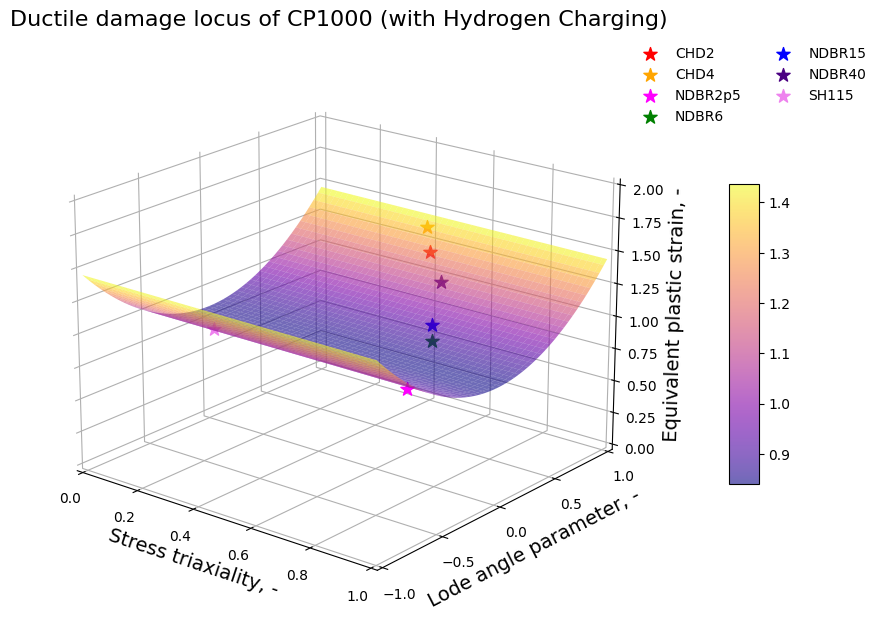

In [101]:

# parameters of locus
# Without Hydrogen Charging (PEEQ)
F1, F2, F3, F4 = 1.455, 0.010, 0.848, 0.010

# With Hydrogen Charging (PEEQ)
# F1, F2, F3, F4 = 0.232, 1.291, 0.000, 0.518

x = np.linspace(0, 1, 200)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)

z1 = (F1 * np.exp(-F2 * x) - F3 * np.exp(-F4 * x)) * y**2 + F3 * np.exp(-F4 * x)


fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection="3d")

# 绘制第一个曲面
surface1 = ax.plot_surface(x, y, z1, cmap="plasma", alpha=0.6)


ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # X-axis pane
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Y-axis pane
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Z-axis pane
fig.colorbar(surface1, ax=ax, shrink=0.5, aspect=10)
ax.set_xlim(0, 1)
ax.set_zlim(0, 2.0)
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('Stress triaxiality, -', fontsize=14)
ax.set_ylabel('Lode angle parameter, -', fontsize=14)
ax.set_zlabel("Equivalent plastic strain, -", fontsize=14)
plt.tight_layout()
ax.view_init(elev=20, azim=-51)
plt.subplots_adjust(left=0, right=1.2, bottom=0, top=1.2)

# plt.title("Ductile damage locus of CP1000 (without Hydrogen Charging)", fontsize=16)
plt.title("Ductile damage locus of CP1000 (with Hydrogen Charging)", fontsize=16)
# Fracture locus (without Hydrogen)

# Without Hydrogen Charging (PEEQ)
scenarios = {
    'CHD2': {'eta': 0.43921234095227807, 'theta': 0.8923667200021577, 'peeq': 1.21572351}, 
    'CHD4': {'eta': 0.420805013253624, 'theta': 0.9116832625639929, 'peeq': 1.3944546}, 
    'NDBR2p5': {'eta': 0.7051183282413369, 'theta': 0.003934203748212394, 'peeq': 0.647949036}, 
    'NDBR6': {'eta': 0.7710209769077397, 'theta': 0.047610828165876175, 'peeq': 1.03478765}, 
    'NDBR15': {'eta': 0.6886682481491765, 'theta': 0.2631436174337343, 'peeq': 1.0222435}, 
    'NDBR40': {'eta': 0.5882302503807374, 'theta': 0.6045504293074565, 'peeq': 1.16820157}, 
    'SH115': {'eta': 0.015098634557346717, 'theta': 0.012139570595352278, 'peeq': 0.671227173}
}

# With Hydrogen charging

# scenarios = {
#     'CHD2': {'eta': 0.3996908156319999, 'theta': 0.9639943405879124, 'peeq': 0.224004974}, 
#     'CHD4': {'eta': 0.34705931061039047, 'theta': 0.9269911957276341, 'peeq': 0.0940357132}, 
#     'NDBR2p5': {'eta': 0.550436985012312, 'theta': 0.14413413992607826, 'peeq': 0.00905476761}, 
#     'NDBR6': {'eta': 0.5042861892750523, 'theta': 0.36266189935565, 'peeq': 0.0313159409}, 
#     'NDBR15': {'eta': 0.4275595171310108, 'theta': 0.671698782162358, 'peeq': 0.057771286}, 
#     'NDBR40': {'eta': 0.373909069855388, 'theta': 0.8635087337058005, 'peeq': 0.0660935211}, 
#     'SH115': {'eta': 0.49219499835301367, 'theta': 0.7679683548145297, 'peeq': 0.0190437508}
# }

colors_mapping = {
    'CHD2': "red",
    'CHD4': "orange",
    'NDBR2p5': "magenta",
    'NDBR6': "green",
    'NDBR15': "blue",
    'NDBR40': "indigo",
    'SH115': "violet"
}

for key ,value in scenarios.items():     
    x1 = value["eta"]
    y1 = value["theta"]
    z1 = value["peeq"]
    ax.scatter(x1, y1, z1,marker='*' ,s=100, c=colors_mapping[key], label=key)

# We need to shift the legend a bit to the right

plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor=(1.4, 1.0))
plt.show()


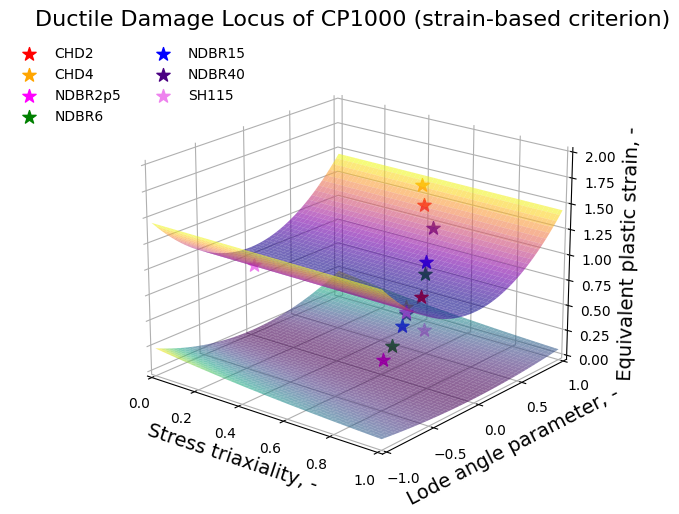

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters of locus
# Without Hydrogen Charging (PEEQ)
F1_1, F2_1, F3_1, F4_1 = 1.455, 0.010, 0.848, 0.010

# With Hydrogen Charging (PEEQ)
F1_2, F2_2, F3_2, F4_2 = 0.232, 1.291, 0.000, 0.518

# Generate meshgrid
x = np.linspace(0, 1, 200)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)

# Calculate the surfaces
z1 = (F1_1 * np.exp(-F2_1 * x) - F3_1 * np.exp(-F4_1 * x)) * y**2 + F3_1 * np.exp(-F4_1 * x)
z2 = (F1_2 * np.exp(-F2_2 * x) - F3_2 * np.exp(-F4_2 * x)) * y**2 + F3_2 * np.exp(-F4_2 * x)

# Set up the figure and 3D axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the first surface
surface1 = ax.plot_surface(x, y, z1, cmap="plasma", alpha=0.6, edgecolor='none')
# Plot the second surface
surface2 = ax.plot_surface(x, y, z2, cmap="viridis", alpha=0.6, edgecolor='none')

# Customize the axes
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# fig.colorbar(surface1, ax=ax, shrink=0.5, aspect=10, label='Without Hydrogen')
# fig.colorbar(surface2, ax=ax, shrink=0.5, aspect=10, label='With Hydrogen')
ax.set_xlim(0, 1)
ax.set_zlim(0, 2.0)
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('Stress triaxiality, -', fontsize=14)
ax.set_ylabel('Lode angle parameter, -', fontsize=14)
ax.set_zlabel("Equivalent plastic strain, -", fontsize=14)
plt.tight_layout()
ax.view_init(elev=20, azim=-51)

# Fracture locus points for both scenarios
# Without Hydrogen Charging
scenarios_1 = {
    'CHD2': {'eta': 0.439, 'theta': 0.892, 'peeq': 1.215}, 
    'CHD4': {'eta': 0.421, 'theta': 0.912, 'peeq': 1.394}, 
    'NDBR2p5': {'eta': 0.705, 'theta': 0.004, 'peeq': 0.648}, 
    'NDBR6': {'eta': 0.771, 'theta': 0.048, 'peeq': 1.035}, 
    'NDBR15': {'eta': 0.689, 'theta': 0.263, 'peeq': 1.022}, 
    'NDBR40': {'eta': 0.588, 'theta': 0.605, 'peeq': 1.168}, 
    'SH115': {'eta': 0.015, 'theta': 0.012, 'peeq': 0.671}
}

# With Hydrogen Charging
scenarios_2 = {
    'CHD2': {'eta': 0.400, 'theta': 0.964, 'peeq': 0.224}, 
    'CHD4': {'eta': 0.347, 'theta': 0.927, 'peeq': 0.094}, 
    'NDBR2p5': {'eta': 0.550, 'theta': 0.144, 'peeq': 0.009}, 
    'NDBR6': {'eta': 0.504, 'theta': 0.363, 'peeq': 0.031}, 
    'NDBR15': {'eta': 0.428, 'theta': 0.672, 'peeq': 0.058}, 
    'NDBR40': {'eta': 0.374, 'theta': 0.864, 'peeq': 0.066}, 
    'SH115': {'eta': 0.492, 'theta': 0.768, 'peeq': 0.019}
}

# Colors for points
colors_mapping = {
    'CHD2': "red",
    'CHD4': "orange",
    'NDBR2p5': "magenta",
    'NDBR6': "green",
    'NDBR15': "blue",
    'NDBR40': "indigo",
    'SH115': "violet"
}

# Plot points for each scenario
for key, value in scenarios_1.items():
    ax.scatter(value["eta"], value["theta"], value["peeq"], marker='*', s=100, c=colors_mapping[key], label=f"{key}")

for key, value in scenarios_2.items():
    ax.scatter(value["eta"], value["theta"], value["peeq"], marker='*', s=100, c=colors_mapping[key])

# Adjust legend
plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor=(0.3, 1.0))
plt.title("Ductile Damage Locus of CP1000 (strain-based criterion)", fontsize=16)
plt.show()


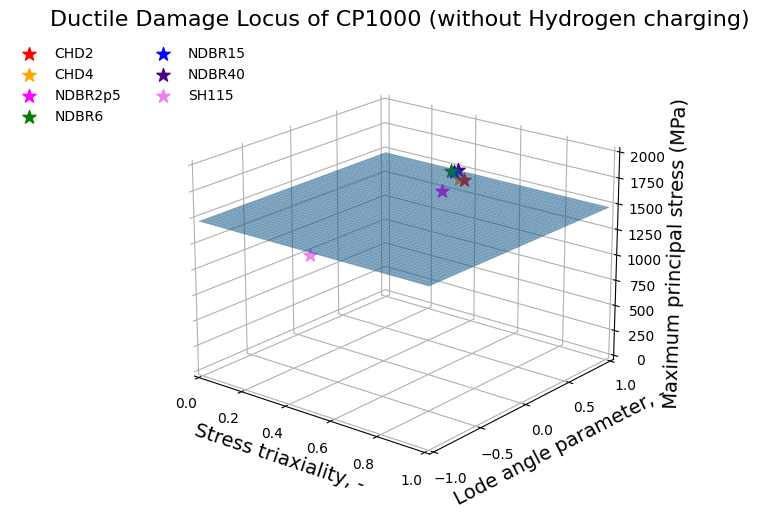

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants for maximum principal stress planes
stress_without_hydrogen = 1.47e+03  # MPa
stress_with_hydrogen = 1.14e+03    # MPa

# Generate meshgrid for x and y
x = np.linspace(0, 1, 200)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)

# Define the z values as constant planes
z1 = np.full_like(x, stress_without_hydrogen)
z2 = np.full_like(x, stress_with_hydrogen)

# Set up the figure and 3D axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the constant planes
plane1 = ax.plot_surface(x, y, z1, alpha=0.6, edgecolor='none')
# plane2 = ax.plot_surface(x, y, z2, alpha=0.6, edgecolor='none')

# Customize the axes
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(0, 1)
ax.set_zlim(0, 2000)  # Adjusted limit to show planes clearly
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('Stress triaxiality, -', fontsize=14)
ax.set_ylabel('Lode angle parameter, -', fontsize=14)
ax.set_zlabel("Maximum principal stress (MPa)", fontsize=14)
plt.tight_layout()
ax.view_init(elev=20, azim=-51)

# Fracture locus points for both scenarios
# Without Hydrogen Charging
scenarios_1 = {
    'CHD2': {'eta': 0.38940417599651916, 'theta': 0.9380300847397904, 'sig_P1': 1418.08331}, 
    'CHD4': {'eta': 0.3645302873013447, 'theta': 0.9373611121647315, 'sig_P1': 1420.3649799999998}, 
    'NDBR2p5': {'eta': 0.5545886217605612, 'theta': 0.25774196324199944, 'sig_P1': 1632.57992}, 
    'NDBR6': {'eta': 0.5628972498124537, 'theta': 0.34147557977526083, 'sig_P1': 1802.11735}, 
    'NDBR15': {'eta': 0.4860912246332384, 'theta': 0.5735430268603692, 'sig_P1': 1677.9417999999998}, 
    'NDBR40': {'eta': 0.4186665310643665, 'theta': 0.7926126003815849, 'sig_P1': 1580.9185499999999}, 
    'SH115': {'eta': 0.02808607122484391, 'theta': 0.07346595461428004, 'sig_P1': 766.150574}
    }


# Colors for points
colors_mapping = {
    'CHD2': "red",
    'CHD4': "orange",
    'NDBR2p5': "magenta",
    'NDBR6': "green",
    'NDBR15': "blue",
    'NDBR40': "indigo",
    'SH115': "violet"
}

# Plot points for each scenario
for key, value in scenarios_1.items():
    ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key], label=f"{key}")

# for key, value in scenarios_2.items():
#     ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key])

# Adjust legend
plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor=(0.2, 1.0))
plt.title("Ductile Damage Locus of CP1000 (without Hydrogen charging)", fontsize=16)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


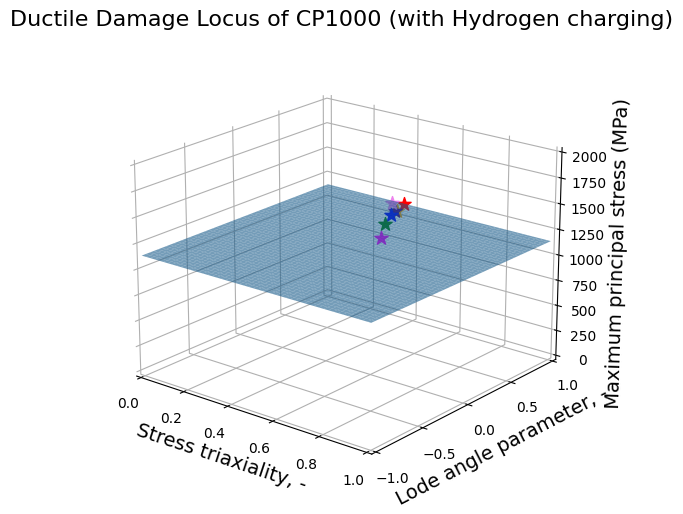

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants for maximum principal stress planes
stress_without_hydrogen = 1.47e+03  # MPa
stress_with_hydrogen = 1.14e+03    # MPa

# Generate meshgrid for x and y
x = np.linspace(0, 1, 200)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)

# Define the z values as constant planes
z1 = np.full_like(x, stress_without_hydrogen)
z2 = np.full_like(x, stress_with_hydrogen)

# Set up the figure and 3D axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the constant planes
# plane1 = ax.plot_surface(x, y, z1, alpha=0.6, edgecolor='none')
plane2 = ax.plot_surface(x, y, z2, alpha=0.6, edgecolor='none')

# Customize the axes
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(0, 1)
ax.set_zlim(0, 2000)  # Adjusted limit to show planes clearly
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('Stress triaxiality, -', fontsize=14)
ax.set_ylabel('Lode angle parameter, -', fontsize=14)
ax.set_zlabel("Maximum principal stress (MPa)", fontsize=14)
plt.tight_layout()
ax.view_init(elev=20, azim=-51)

# Fracture locus points for both scenarios
# Without Hydrogen Charging
# With Hydrogen Charging
scenarios_2 = {
    'CHD2': {'eta': 0.37555441050518534, 'theta': 0.9532556611098932, 'sig_P1': 1167.8621799999999}, 
    'CHD4': {'eta': 0.3466247243691898, 'theta': 0.9447672274642216, 'sig_P1': 1079.51331}, 
    'NDBR2p5': {'eta': 0.4971161353322698, 'theta': 0.3723955255740523, 'sig_P1': 1098.65272},
     'NDBR6': {'eta': 0.46967061613902594, 'theta': 0.48849196873489914, 'sig_P1': 1178.6322599999999}, 
     'NDBR15': {'eta': 0.4122203968861092, 'theta': 0.7061334443705655, 'sig_P1': 1156.7724899999998}, 
     'NDBR40': {'eta': 0.3628312451434025, 'theta': 0.8753045151574453, 'sig_P1': 1112.85782}, 
     'SH115': {'eta': 0.35633917592169523, 'theta': 0.859182223831446, 'sig_P1': 1198.06468}
}


# Colors for points
colors_mapping = {
    'CHD2': "red",
    'CHD4': "orange",
    'NDBR2p5': "magenta",
    'NDBR6': "green",
    'NDBR15': "blue",
    'NDBR40': "indigo",
    'SH115': "violet"
}

# Plot points for each scenario
# for key, value in scenarios_1.items():
#     ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key], label=f"{key}")

for key, value in scenarios_2.items():
    ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key])

# Adjust legend
plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor=(0.2, 1.0))
plt.title("Ductile Damage Locus of CP1000 (with Hydrogen charging)", fontsize=16)
plt.show()


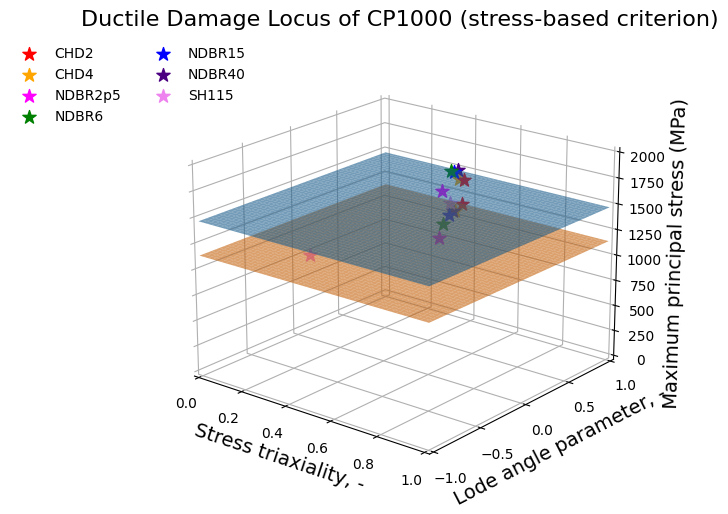

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants for maximum principal stress planes
stress_without_hydrogen = 1.47e+03  # MPa
stress_with_hydrogen = 1.14e+03    # MPa

# Generate meshgrid for x and y
x = np.linspace(0, 1, 200)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y)

# Define the z values as constant planes
z1 = np.full_like(x, stress_without_hydrogen)
z2 = np.full_like(x, stress_with_hydrogen)

# Set up the figure and 3D axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the constant planes
plane1 = ax.plot_surface(x, y, z1, alpha=0.6, edgecolor='none')
plane2 = ax.plot_surface(x, y, z2, alpha=0.6, edgecolor='none')

# Customize the axes
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlim(0, 1)
ax.set_zlim(0, 2000)  # Adjusted limit to show planes clearly
ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_xlabel('Stress triaxiality, -', fontsize=14)
ax.set_ylabel('Lode angle parameter, -', fontsize=14)
ax.set_zlabel("Maximum principal stress (MPa)", fontsize=14)
plt.tight_layout()
ax.view_init(elev=20, azim=-51)

# Fracture locus points for both scenarios
# Without Hydrogen Charging
scenarios_1 = {
    'CHD2': {'eta': 0.38940417599651916, 'theta': 0.9380300847397904, 'sig_P1': 1418.08331}, 
    'CHD4': {'eta': 0.3645302873013447, 'theta': 0.9373611121647315, 'sig_P1': 1420.3649799999998}, 
    'NDBR2p5': {'eta': 0.5545886217605612, 'theta': 0.25774196324199944, 'sig_P1': 1632.57992}, 
    'NDBR6': {'eta': 0.5628972498124537, 'theta': 0.34147557977526083, 'sig_P1': 1802.11735}, 
    'NDBR15': {'eta': 0.4860912246332384, 'theta': 0.5735430268603692, 'sig_P1': 1677.9417999999998}, 
    'NDBR40': {'eta': 0.4186665310643665, 'theta': 0.7926126003815849, 'sig_P1': 1580.9185499999999}, 
    'SH115': {'eta': 0.02808607122484391, 'theta': 0.07346595461428004, 'sig_P1': 766.150574}
    }



# With Hydrogen Charging
scenarios_2 = {
    'CHD2': {'eta': 0.37555441050518534, 'theta': 0.9532556611098932, 'sig_P1': 1167.8621799999999}, 
    'CHD4': {'eta': 0.3466247243691898, 'theta': 0.9447672274642216, 'sig_P1': 1079.51331}, 
    'NDBR2p5': {'eta': 0.4971161353322698, 'theta': 0.3723955255740523, 'sig_P1': 1098.65272},
     'NDBR6': {'eta': 0.46967061613902594, 'theta': 0.48849196873489914, 'sig_P1': 1178.6322599999999}, 
     'NDBR15': {'eta': 0.4122203968861092, 'theta': 0.7061334443705655, 'sig_P1': 1156.7724899999998}, 
     'NDBR40': {'eta': 0.3628312451434025, 'theta': 0.8753045151574453, 'sig_P1': 1112.85782}, 
     'SH115': {'eta': 0.35633917592169523, 'theta': 0.859182223831446, 'sig_P1': 1198.06468}
}

# Colors for points
colors_mapping = {
    'CHD2': "red",
    'CHD4': "orange",
    'NDBR2p5': "magenta",
    'NDBR6': "green",
    'NDBR15': "blue",
    'NDBR40': "indigo",
    'SH115': "violet"
}

# Plot points for each scenario
for key, value in scenarios_1.items():
    ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key], label=f"{key}")

for key, value in scenarios_2.items():
    ax.scatter(value["eta"], value["theta"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key])

# Adjust legend
plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor=(0.2, 1.0))
plt.title("Ductile Damage Locus of CP1000 (stress-based criterion)", fontsize=16)
plt.show()


Text(0.5, 0, 'Maximum principal stress, MPa')

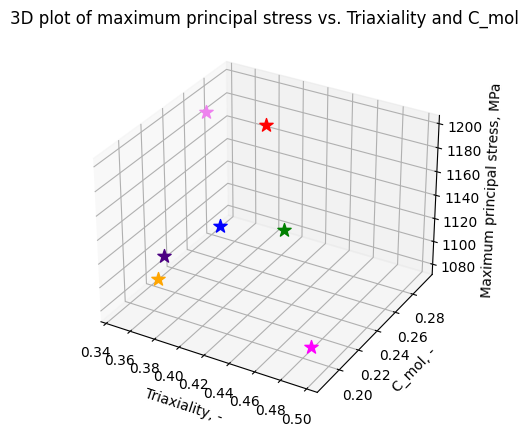

In [133]:
scenario_sig_p1_Cmol_triaxiality = {'CHD2': {'eta': 0.37555441050518534, 'C_mol': 0.29455620630372503, 'sig_P1': 1167.8621799999999}, 'CHD4': {'eta': 0.3466247243691898, 'C_mol': 0.219139094555874, 'sig_P1': 1079.51331}, 'NDBR2p5': {'eta': 0.4971161353322698, 'C_mol': 0.18579088825214907, 'sig_P1': 1098.65272}, 'NDBR6': {'eta': 0.46967061613902594, 'C_mol': 0.19368020630372507, 'sig_P1': 1178.6322599999999}, 'NDBR15': {'eta': 0.4122203968861092, 'C_mol': 0.20386402292263606, 'sig_P1': 1156.7724899999998}, 'NDBR40': {'eta': 0.3628312451434025, 'C_mol': 0.20758242979942687, 'sig_P1': 1112.85782}, 'SH115': {'eta': 0.35633917592169523, 'C_mol': 0.25722179942693435, 'sig_P1': 1198.06468}}
scenario_sig_p1_Cmol_lode = {'CHD2': {'eta': 0.9532556611098932, 'C_mol': 0.29455620630372503, 'sig_P1': 1167.8621799999999}, 'CHD4': {'eta': 0.9447672274642216, 'C_mol': 0.219139094555874, 'sig_P1': 1079.51331}, 'NDBR2p5': {'eta': 0.3723955255740523, 'C_mol': 0.18579088825214907, 'sig_P1': 1098.65272}, 'NDBR6': {'eta': 0.48849196873489914, 'C_mol': 0.19368020630372507, 'sig_P1': 1178.6322599999999}, 'NDBR15': {'eta': 0.7061334443705655, 'C_mol': 0.20386402292263606, 'sig_P1': 1156.7724899999998}, 'NDBR40': {'eta': 0.8753045151574453, 'C_mol': 0.20758242979942687, 'sig_P1': 1112.85782}, 'SH115': {'eta': 0.859182223831446, 'C_mol': 0.25722179942693435, 'sig_P1': 1198.06468}}
scenario_PEEQ_Cmol_triaxiality = {'CHD2': {'eta': 0.3996908156319999, 'C_mol': 0.29455620630372503, 'peeq': 2.2400497399999998e-07}, 'CHD4': {'eta': 0.34705931061039047, 'C_mol': 0.219139094555874, 'peeq': 9.403571319999999e-08}, 'NDBR2p5': {'eta': 0.550436985012312, 'C_mol': 0.18579088825214907, 'peeq': 9.05476761e-09}, 'NDBR6': {'eta': 0.5042861892750523, 'C_mol': 0.19368020630372507, 'peeq': 3.1315940899999997e-08}, 'NDBR15': {'eta': 0.4275595171310108, 'C_mol': 0.20386402292263606, 'peeq': 5.7771285999999994e-08}, 'NDBR40': {'eta': 0.373909069855388, 'C_mol': 0.20758242979942687, 'peeq': 6.609352109999999e-08}, 'SH115': {'eta': 0.49219499835301367, 'C_mol': 0.25722179942693435, 'peeq': 1.9043750799999998e-08}}
scenario_PEEQ_Cmol_lode = {'CHD2': {'eta': 0.9639943405879124, 'C_mol': 0.29455620630372503, 'peeq': 2.2400497399999998e-07}, 'CHD4': {'eta': 0.9269911957276341, 'C_mol': 0.219139094555874, 'peeq': 9.403571319999999e-08}, 'NDBR2p5': {'eta': 0.14413413992607826, 'C_mol': 0.18579088825214907, 'peeq': 9.05476761e-09}, 'NDBR6': {'eta': 0.36266189935565, 'C_mol': 0.19368020630372507, 'peeq': 3.1315940899999997e-08}, 'NDBR15': {'eta': 0.671698782162358, 'C_mol': 0.20386402292263606, 'peeq': 5.7771285999999994e-08}, 'NDBR40': {'eta': 0.8635087337058005, 'C_mol': 0.20758242979942687, 'peeq': 6.609352109999999e-08}, 'SH115': {'eta': 0.7679683548145297, 'C_mol': 0.25722179942693435, 'peeq': 1.9043750799999998e-08}}


# Plot them in 3D space

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection="3d")

# Plot the points
for key, value in scenario_sig_p1_Cmol_triaxiality.items():
    ax.scatter(value["eta"], value["C_mol"], value["sig_P1"], marker='*', s=100, c=colors_mapping[key], label=f"{key}")

for 
plt.xlabel("Triaxiality, -")
plt.ylabel("C_mol, -")
plt.title("3D plot of maximum principal stress vs. Triaxiality and C_mol")
ax.set_zlabel("Maximum principal stress, MPa")
